In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization
#from keras import layers
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount("/content/drive") # Don't change this.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x = np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended t1ce/t1ce.npy')

y = np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/appended all/training/appended masks/masks.npy')

In [ ]:
x.shape,y.shape

((195, 128, 128, 128), (195, 128, 128, 128))

** lets visulize some images **

<function matplotlib.pyplot.imshow>

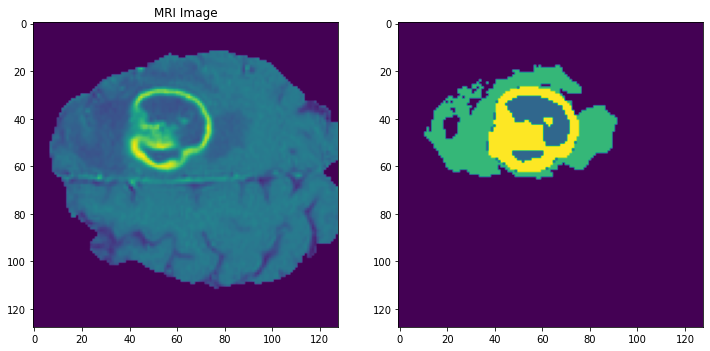

In [ ]:
rand=np.random.randint(0,127 )
rand_2=np.random.randint(0,127)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('MRI Image')
plt.imshow(x[rand,:,:,rand_2])
plt.subplot(122)
plt.imshow(y[rand,:,:,rand_2])
plt.imshow

In [ ]:
image2D = []
mask2D = []
for i in range(195):
  for j in range(128):
    image2D.append(x[i,:,:,j])
    mask2D.append(y[i,:,:,j])

x = np.array(image2D)
y=np.array(mask2D)

In [ ]:
image2D=0
mask2D=0

In [ ]:
x.shape,y.shape

((24960, 128, 128), (24960, 128, 128))

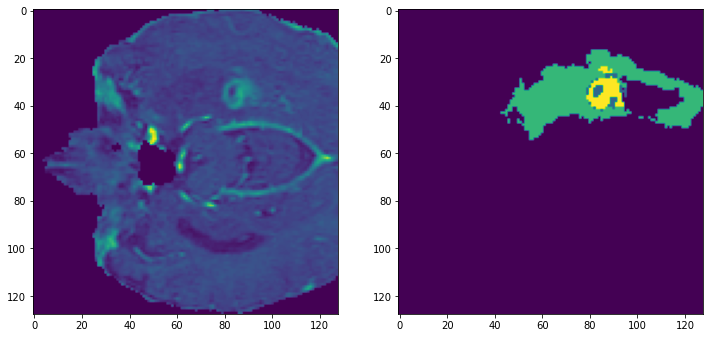

In [ ]:
import random
ra = random.randint(0,24960)
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(x[ra,:,:])
plt.subplot(122)
plt.imshow(y[ra,:,:])


**Training and validation Split**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.20, random_state = 101)

In [ ]:
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((19968, 128, 128), (4992, 128, 128), (19968, 128, 128), (4992, 128, 128))

**Training and test split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.20, random_state = 101)

In [ ]:
x_train.shape,y_test.shape,y_train.shape

((15974, 128, 128), (3994, 128, 128), (15974, 128, 128))

** Lets visualize some images **

(15974, 128, 128)

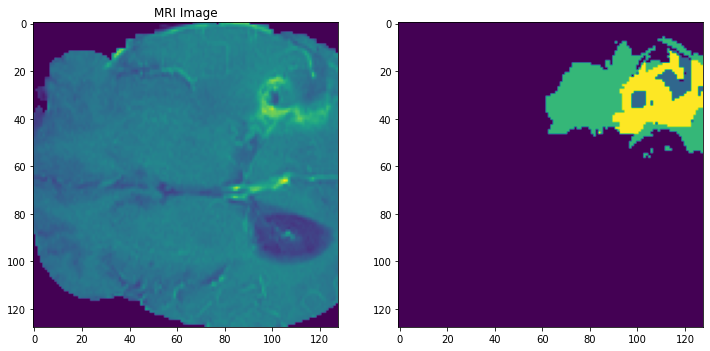

In [ ]:
rand=np.random.randint(0,15974 )
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('MRI Image')
plt.imshow(x_train[rand])
plt.subplot(122)
plt.imshow(y_train[rand])
plt.imshow
y_train.shape

In [ ]:
x_train = np.expand_dims(x_train, axis = 3)
x_val = np.expand_dims(x_val, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)

In [ ]:
x_train.shape,x_val.shape,x_test.shape

((15974, 128, 128, 1), (4992, 128, 128, 1), (3994, 128, 128, 1))

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_train.shape,y_val.shape,y_test.shape

((15974, 128, 128, 4), (4992, 128, 128, 4), (3994, 128, 128, 4))

** Lets introduce some metrics to compute the efficecy **

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


** model with MAXUNPOOLING  **

In [ ]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        print("no idea what this is: but computing mask")
        return 2 * [None]


'''class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )'''
class MaxUnpooling2D(Layer):
      def __init__(self, size=(2, 2), **kwargs):
          super(MaxUnpooling2D, self).__init__(**kwargs)
          self.size = size

      def call(self, inputs, output_shape=None):
          updates, mask = inputs[0], inputs[1]
          with tf.compat.v1.variable_scope(self.name):
              mask = K.cast(mask, 'int32')
              input_shape = tf.shape(updates, out_type='int32')
              #print(updates.shape)
              #print(mask.shape)
              if output_shape is None:
                  output_shape = (
                      input_shape[0],
                      input_shape[1] * self.size[0],
                      input_shape[2] * self.size[1],
                      input_shape[3])

              ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                    K.flatten(updates),
                                    [K.prod(output_shape)])

              input_shape = updates.shape
              out_shape = [-1,
                          input_shape[1] * self.size[0],
                          input_shape[2] * self.size[1],
                          input_shape[3]]
          return K.reshape(ret, out_shape)

      def get_config(self):
          config = super().get_config().copy()
          config.update({
              'size': self.size
          })
          return config

      def compute_output_shape(self, input_shape):
          mask_shape = input_shape[1]
          return (
                  mask_shape[0],
                  mask_shape[1]*self.size[0],
                  mask_shape[2]*self.size[1],
                  mask_shape[3]
                  )

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(4)(conv_26)
    '''conv_26 = Reshape(
        (input_shape[0] * input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)'''
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

model = segnet(input_shape=(128,128,1), n_labels=4)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
Build decoder done..


In [ ]:
model.summary()
model.compile(optimizer= Adam(learning_rate=0.001, decay=0.05), loss= ["categorical_crossentropy"]
                  , metrics=['acc'])

Model: "SegNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_____________________________________________________________________________________________

** Jugard.... saing xtest,xtrain, saving ram **

In [ ]:
np.save("/content/drive/MyDrive/brain tumor segmentation/asad data/data/unused variables_xtest",x_test)
np.save("/content/drive/MyDrive/brain tumor segmentation/asad data/data/unused variables_y_test",y_test)

In [ ]:
#####USe this only to save ram
x_test=0
y_test=0


In [ ]:
x_test

0

In [ ]:
hist = model.fit(x_train, y_train, epochs= 60, batch_size= 50, validation_data= (x_val, y_val), verbose=1)

Epoch 1/60
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
320/320 [==============================] - ETA: 0s - loss: 1.3112 - acc: 0.9437max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask


In [ ]:
model.save('/content/drive/MyDrive/brain tumor segmentation/asad data/save models')

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
max pooling with argmax
max pooling with argmax
max pooling with argmax
max pooling with argmax
no idea what this is: but computing mask
no idea what this is: but computing mask
no idea what this is: but computing mask
no idea what this is: but computing mask
no idea what this is: but computing mask
no idea what this is: but

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
prediction = model.predict(x_val)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask


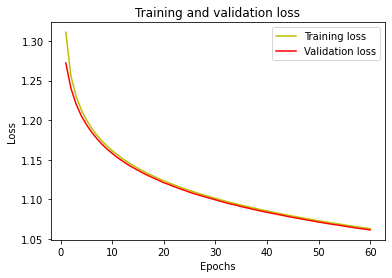

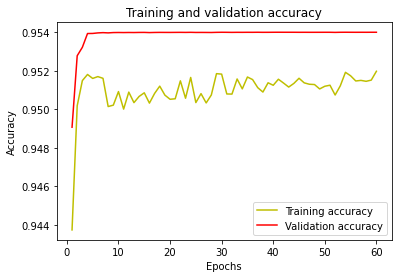

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
x_test=np.load('/content/drive/MyDrive/brain tumor segmentation/asad data/data/unused variables_xtest.npy')

In [ ]:
y_test=np.load("/content/drive/MyDrive/brain tumor segmentation/asad data/data/unused variables_y_test.npy")

In [ ]:
preds=model.predict(x_test)

max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask
max pooling with argmax
no idea what this is: but computing mask


In [ ]:
preds.shape

(3994, 128, 128, 4)

In [ ]:
iou_matric=tf.keras.metrics.MeanIoU(
    4, name=None, dtype=None
)

In [ ]:
iou_matric.update_state(y_test,preds)

<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[1.6777216e+07, 1.1800000e+02, 0.0000000e+00, 0.0000000e+00],
       [1.6777216e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)>

In [ ]:
iou_matric.result().numpy()

0.2499991

In [ ]:
dice_coef_matric=dice_coef(y_test,preds)
dice_coef_matric

<tf.Tensor: shape=(), dtype=float32, numpy=0.34868082>

In [ ]:
accuracy_matric=accuracy(y_test,preds)

In [ ]:
accuracy_matric

<tf.Tensor: shape=(), dtype=float32, numpy=0.7500011>